# Bank Customer Churn Prediction Using Spark ML

This project is a part of Advanced Data Science Capstone course.

### Use Case and Business Requirements
- Build Model: Based on the historical bank customer data to create a Churn Prediction Model which provides prediction of customer/clients who most likely to cancle or leave the service with 87% or greater accuracy.

- Deploy Model: Deploying the model to Watson Machine Learning for the Model Evaluation.

### Overall Model Pipeline
1. Data cleaning
2. Exploratory data analysis
3. Feature creation
4. Compare several machine learning models using hyperparameter tuning and CrossValidation
5. Make predictions and evaluate model performance

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:red">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')

In [2]:
# !pip install pyspark==3.2.1

In [3]:
# !pip install --upgrade pyspark

In [4]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [5]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.types import StructType, StructField, DoubleType, IntegerType, StringType
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/23 13:18:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
#For Data loading and preprocessing
import pandas as pd

#For matrix operations
import numpy as np
import itertools

#For plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#For encoding the features
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix

#For building model
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression, GBTClassifier, MultilayerPerceptronClassifier, MultilayerPerceptronClassificationModel

#For ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## 1. Importing the Dataset

In [64]:
url = 'https://raw.githubusercontent.com/jsutthida/Advanced-Data-Science-with-IBM-Specialization/main/Advanced%20Data%20Science%20Capstone/Churn_Modelling.csv'

In [65]:
df = pd.read_csv(url)
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


### Checking missing values in dataset
We can see there are no Null values in the dataset

In [67]:
df.isnull().any()

RowNumber          False
CustomerId         False
Surname            False
CreditScore        False
Geography          False
Gender             False
Age                False
Tenure             False
Balance            False
NumOfProducts      False
HasCrCard          False
IsActiveMember     False
EstimatedSalary    False
Exited             False
dtype: bool

In [68]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

### Removing unwanted features
RowNumber, CustomerId and Surname which are not necessary for prediction

In [70]:
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)
df.shape

(10000, 11)

## 2. Exploratory Data Analysis
we defined 0 : retained customer, 1 : churned customer

From pie chart below, we can see the proportion of churned customer is aronded 20% and retained customer is aronded 80%

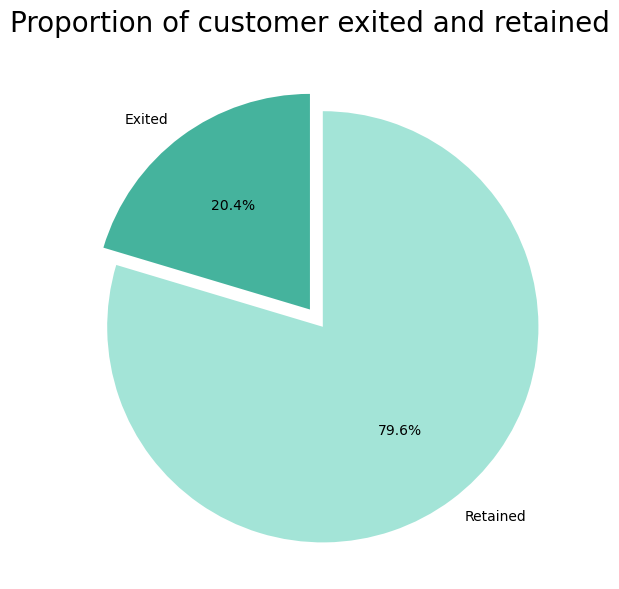

In [71]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
colors = ['#45B39D', '#A3E4D7']
fig1, ax1 = plt.subplots(figsize=(9, 7))
ax1.pie(sizes, explode=explode, labels=labels, colors = colors, autopct='%1.1f%%', startangle=90)
plt.title("Proportion of customer exited and retained", size = 20)
plt.show()

Correlation analysis: All the features are not correlated.

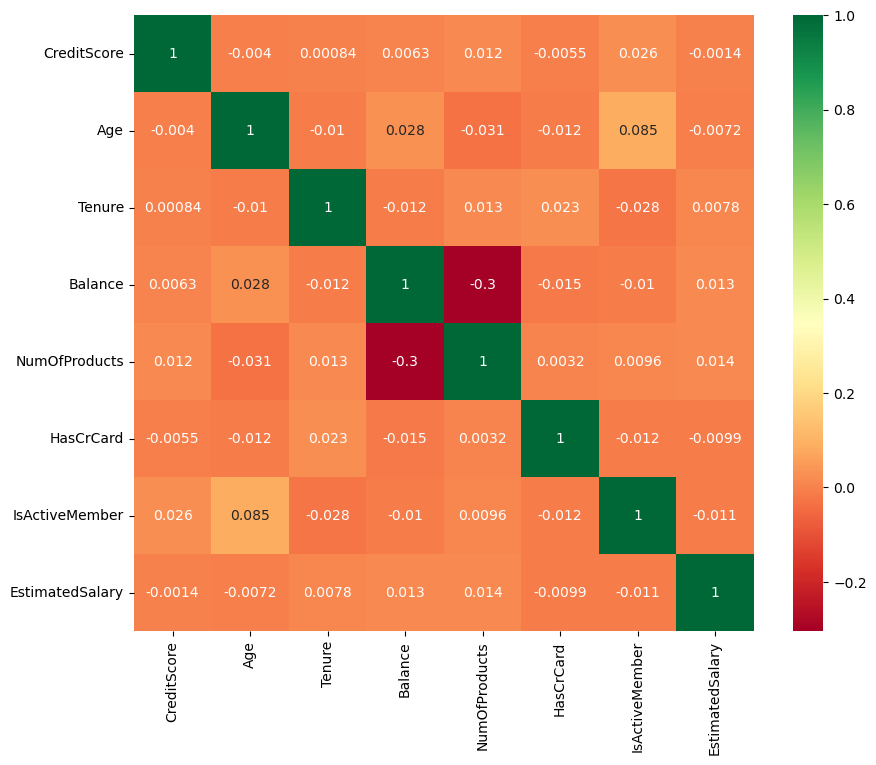

In [72]:
sns.heatmap(df[df.columns[:10]].corr(),annot=True,cmap='RdYlGn')
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

Now lets visualizing countplots for categorical features

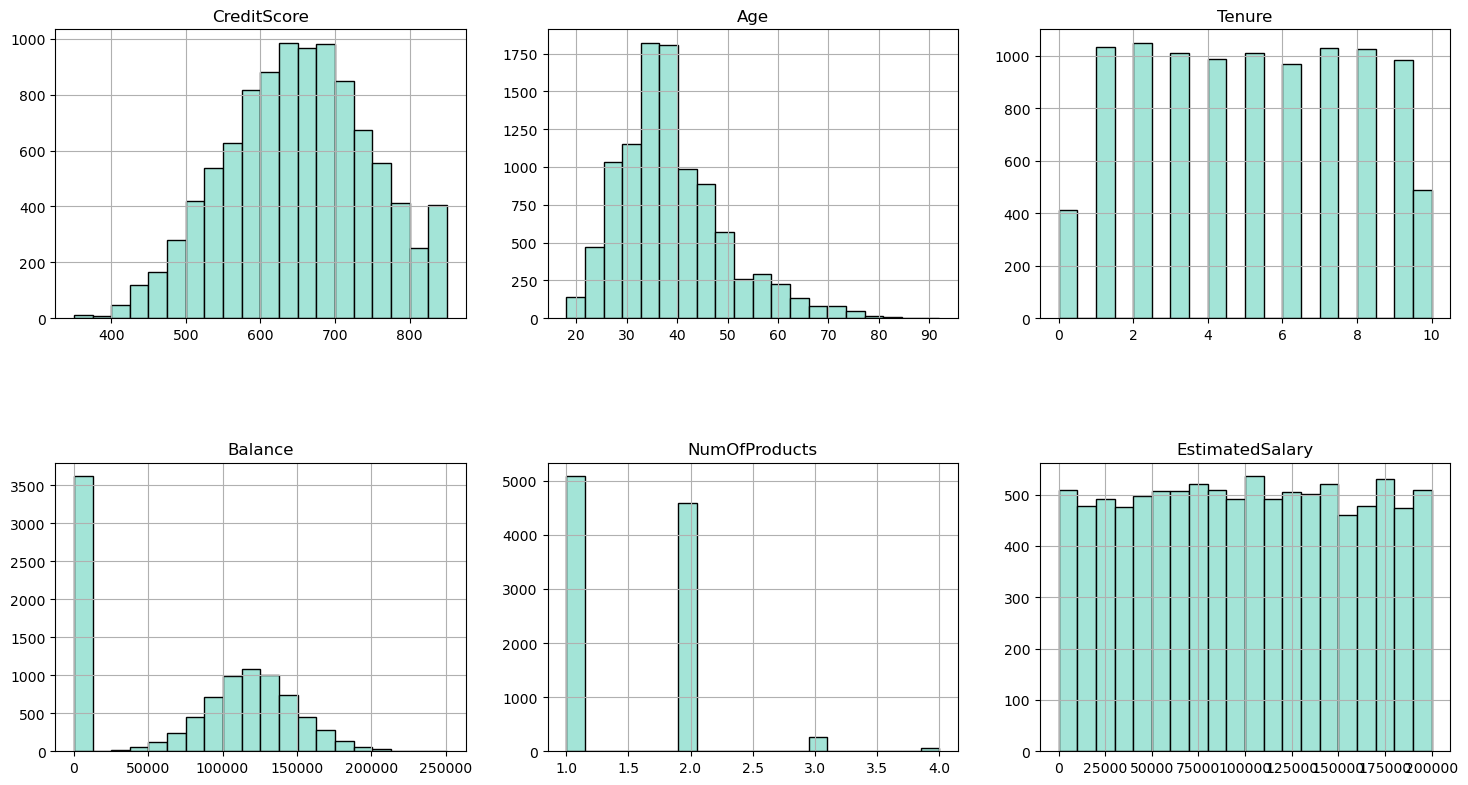

In [73]:
columns=['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
plt.subplots(figsize=(18,15))
length=len(columns)
for i,j in itertools.zip_longest(columns,range(length)):
    plt.subplot((length//2),3,j+1)
    plt.subplots_adjust(wspace=0.2,hspace=0.5)
    df[i].hist(bins=20,edgecolor='black', color = "#A3E4D7")
    plt.title(i)
plt.show()

Text(0.5, 1.0, 'Countplot of Geography')

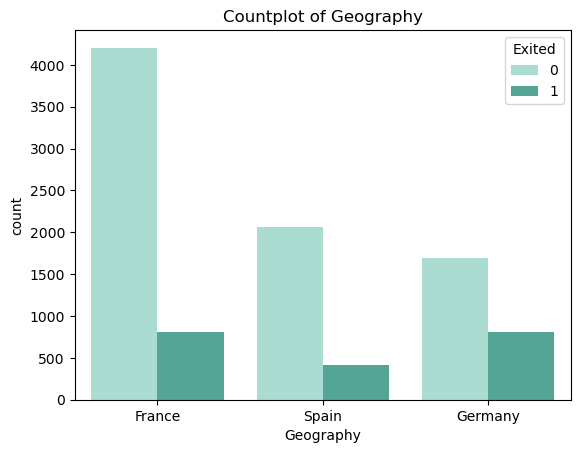

In [74]:
sns.countplot(x='Geography', hue = 'Exited', data = df, palette = ["#A3E4D7", "#45B39D"]).set_title('Countplot of Geography')

Text(0.5, 1.0, 'Countplot of Gender')

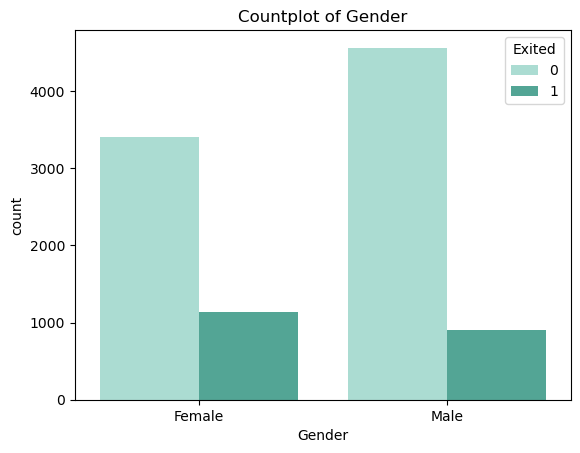

In [75]:
sns.countplot(x='Gender', hue = 'Exited',data = df, palette = ["#A3E4D7", "#45B39D"]).set_title('Countplot of Gender')

Text(0.5, 1.0, 'Countplot of Has CreditCard')

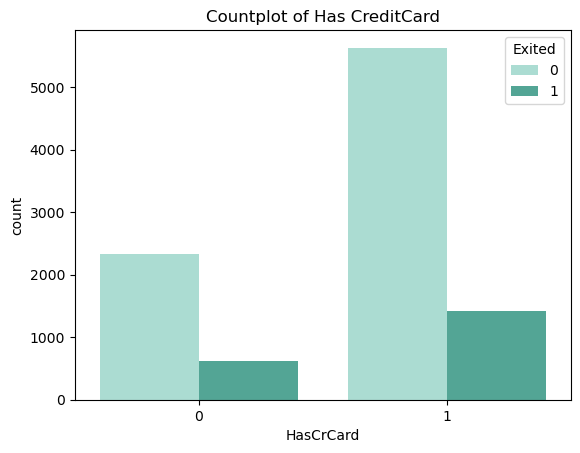

In [76]:
sns.countplot(x='HasCrCard', hue = 'Exited',data = df, palette = ["#A3E4D7", "#45B39D"]).set_title('Countplot of Has CreditCard')

Text(0.5, 1.0, 'Countplotof IsActiveMember')

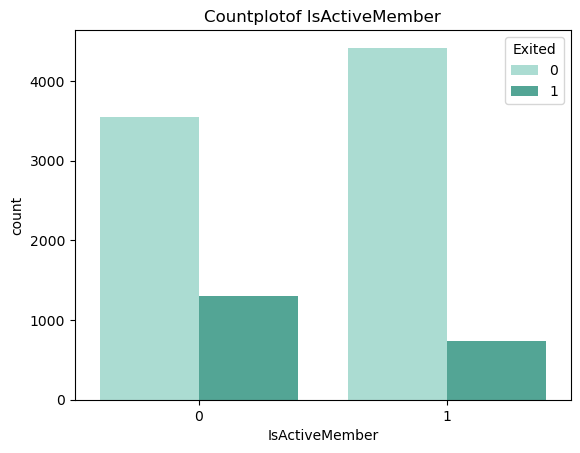

In [77]:
sns.countplot(x='IsActiveMember', hue = 'Exited',data = df, palette = ["#A3E4D7", "#45B39D"]).set_title('Countplotof IsActiveMember')

From the countplots above we can concluded that

1. France customer has the highest retained number among Spain and Germany customer 
2. Female customer has more churned than Male customer 
3. Customer who has credit card has more churned than who not 
4. Inactive members has churned more 

Now lets check for outliers

<Axes: >

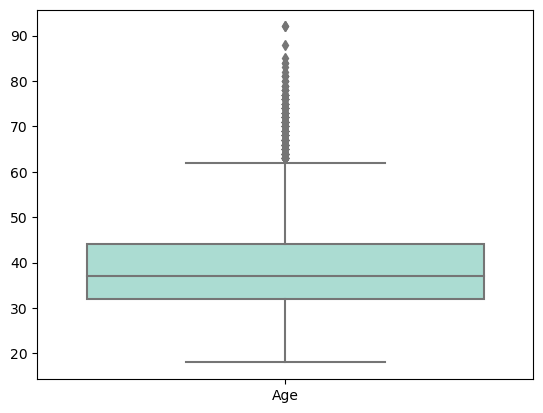

In [78]:
#Outliers we are checking only for numerical features
sns.boxplot(df[['Age']], color = "#A3E4D7")

<Axes: >

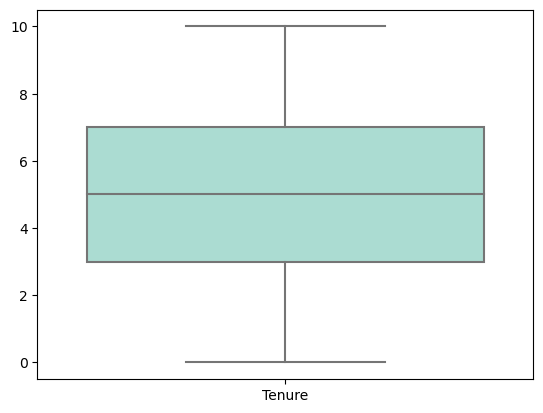

In [79]:
sns.boxplot(df[['Tenure']], color = "#A3E4D7")

<Axes: >

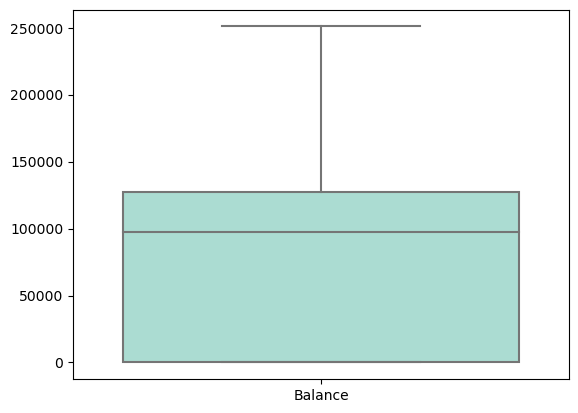

In [80]:
sns.boxplot(df[['Balance']], color = "#A3E4D7")

<Axes: >

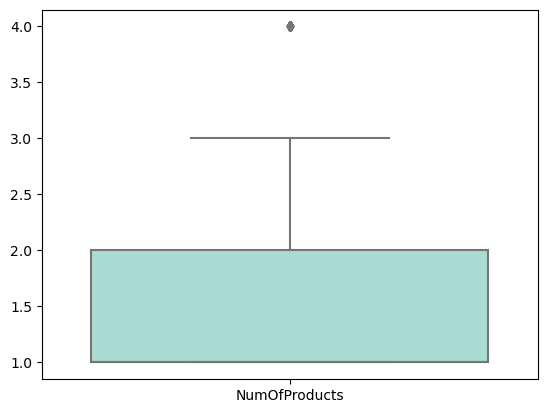

In [81]:
sns.boxplot(df[['NumOfProducts']], color = "#A3E4D7")

<Axes: >

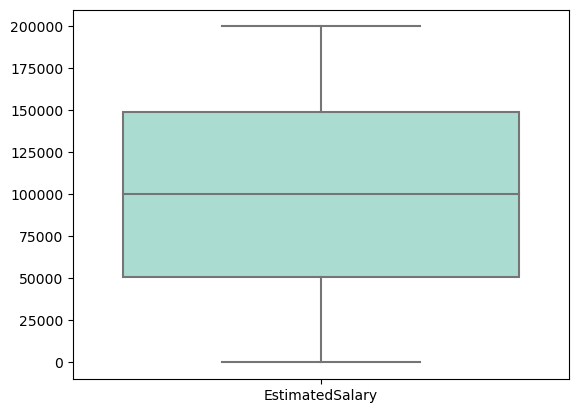

In [82]:
sns.boxplot(df[['EstimatedSalary']], color = "#A3E4D7")

## 3. Data pre-processing and Feature engineering
From the EDA we observed that there are few categorical variables that need to do One-hot encoding all these features into values:
Geography, Gender

In [83]:
Geography_encode = LabelEncoder()
df['Geography']=Geography_encode.fit_transform(df['Geography'])

Gender_encode = LabelEncoder()
df['Gender']=Gender_encode.fit_transform(df['Gender'])

# Gender 0-Female,1-Male
# Geography 0-France,1-Germany,2-Spain

In [84]:
df.to_csv('bankchurn.csv')

## 4. Building Model
For Modeling the data, we will try a different machine learning and deep learning algorithms to finding which algorithms gives the best performed in this project. Since this is classification problem, we will using the following algorithms: Logisitic Regression, Gradient Boost Tree Classifier and Feedforward Neaural Network by using Hyperparameter tuning and K-fold Crossvalidation helps to find the optimal set of hyperparameters and traning with an unknown dataset for a model.

In [86]:
data = spark.read.csv("bankchurn.csv",inferSchema =True,header=True) 
data.dtypes

[('_c0', 'int'),
 ('CreditScore', 'int'),
 ('Geography', 'int'),
 ('Gender', 'int'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('Exited', 'int')]

In [87]:
data = data.drop('_c0')

In [88]:
data.dtypes

[('CreditScore', 'int'),
 ('Geography', 'int'),
 ('Gender', 'int'),
 ('Age', 'int'),
 ('Tenure', 'int'),
 ('Balance', 'double'),
 ('NumOfProducts', 'int'),
 ('HasCrCard', 'int'),
 ('IsActiveMember', 'int'),
 ('EstimatedSalary', 'double'),
 ('Exited', 'int')]

In [15]:
splits = data.randomSplit([0.8, 0.2])
df_train = splits[0]
df_test = splits[1]

In [16]:
from pyspark.ml import Pipeline, Model
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler

stringIndexer_label = StringIndexer(inputCol="Exited", outputCol="label").fit(data)

vectorAssembler = VectorAssembler(inputCols=['CreditScore','Geography', 'Gender', 'Age', 'Tenure','Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
                                  outputCol="features")

model_df = vectorAssembler.transform(data)

normalizer = MinMaxScaler(inputCol="features", outputCol="features_norm")

In [17]:
transform_df_pipeline = Pipeline(stages=[stringIndexer_label, vectorAssembler, normalizer])
transformed_df = transform_df_pipeline.fit(data).transform(data)
transformed_df.show()

+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----+--------------------+--------------------+
|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|label|            features|       features_norm|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----+--------------------+--------------------+
|        619|        0|     0| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|  1.0|[619.0,0.0,0.0,42...|[0.538,0.0,0.0,0....|
|        608|        2|     0| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|  0.0|[608.0,2.0,0.0,41...|[0.516,1.0,0.0,0....|
|        502|        0|     0| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|  1.0|[502.0,0.0,0.0,42...|[0.304,0.0,0.0,0....|
|        699|        0|     

In [18]:
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel", labels=stringIndexer_label.labels)

### Logistic Regression

In [89]:
lr = LogisticRegression(featuresCol = "features_norm", labelCol = "label")
pipeline_lr = Pipeline(stages=[stringIndexer_label, vectorAssembler, normalizer, lr, labelConverter])

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

evaluator = BinaryClassificationEvaluator()

lrcrossval = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
lrcvModel = lrcrossval.fit(df_train)
predictions_lr = lrcvModel.transform(df_test)
predictions_lr_pandas = predictions_lr.toPandas()


# Calculate and print f1, recall and precision scores
accuracy = accuracy_score(predictions_lr_pandas.label, predictions_lr_pandas.prediction)
cm = confusion_matrix(predictions_lr_pandas.label, predictions_lr_pandas.prediction)
auroc = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions_lr, {evaluator.metricName: "areaUnderPR"})

print('Logistic Regression Metrics:')
print('Accuracy: {:.3f}'.format(accuracy))
print("Area under ROC Curve: {:.3f}".format(auroc))
print("Area under PR Curve: {:.3f}".format(auprc))
print('Confusion Matrix: {}'.format(cm))

Logistic Regression Metrics:
Accuracy: 0.815
Area under ROC Curve: 0.763
Area under PR Curve: 0.399
Confusion Matrix: [[1673    0]
 [ 379    0]]


### Gradient Boost Tree Classifier

In [19]:
gbt = GBTClassifier(featuresCol = "features_norm", labelCol = "label")
pipeline_gbt = Pipeline(stages=[stringIndexer_label, vectorAssembler, normalizer, gbt, labelConverter])

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())
evaluator = BinaryClassificationEvaluator()

gbtcrossval = CrossValidator(estimator=pipeline_gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
gbtcvModel = gbtcrossval.fit(df_train)
predictions_gbt = gbtcvModel.transform(df_test)
predictions_gbt_pandas = predictions_gbt.toPandas()

# Calculate and print f1, recall and precision scores
accuracy = accuracy_score(predictions_gbt_pandas.label, predictions_gbt_pandas.prediction)
cm = confusion_matrix(predictions_gbt_pandas.label, predictions_gbt_pandas.prediction)
auroc = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions_gbt, {evaluator.metricName: "areaUnderPR"})

print('Gradient Boosted Trees Metrics:')
print('Accuracy: {:.3f}'.format(accuracy))
print("Area under ROC Curve: {:.3f}".format(auroc))
print("Area under PR Curve: {:.3f}".format(auprc))
print('Confusion Matrix: {}'.format(cm))

24/03/23 13:19:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/03/23 13:19:16 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/03/23 13:20:40 WARN BlockManager: Asked to remove block broadcast_2874_piece0, which does not exist


Gradient Boosted Trees Metrics:
Accuracy: 0.874
Area under ROC Curve: 0.864
Area under PR Curve: 0.671
Confusion Matrix: [[1612   61]
 [ 198  181]]


### Feedforward Neural Network (FNN)
A feedforward neural network is an artificial neural network wherein connections between the units, the information moves in only one direction, from the input nodes, through the hidden nodes and to the output nodes. There are no cycles or loops in the network.

In [90]:
# convert the data to dense vector
def transData(data):
    return data.rdd.map(lambda r: [r[-1], Vectors.dense(r[:-1])]).\
           toDF(['label','features'])

from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

data= transData(data)
data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[619.0,0.0,0.0,42...|
|    0|[608.0,2.0,0.0,41...|
|    1|[502.0,0.0,0.0,42...|
|    0|[699.0,0.0,0.0,39...|
|    0|[850.0,2.0,0.0,43...|
|    1|[645.0,2.0,1.0,44...|
|    0|[822.0,0.0,1.0,50...|
|    1|[376.0,1.0,0.0,29...|
|    0|[501.0,0.0,1.0,44...|
|    0|[684.0,0.0,1.0,27...|
|    0|[528.0,0.0,1.0,31...|
|    0|[497.0,2.0,1.0,24...|
|    0|[476.0,0.0,0.0,34...|
|    0|[549.0,0.0,0.0,25...|
|    0|[635.0,2.0,0.0,35...|
|    0|[616.0,1.0,1.0,45...|
|    1|[653.0,1.0,1.0,58...|
|    0|[549.0,2.0,0.0,24...|
|    0|[587.0,2.0,1.0,45...|
|    0|[726.0,0.0,0.0,24...|
+-----+--------------------+
only showing top 20 rows



Index labels, adding metadata to the label column and fit on whole dataset to include all labels in index. Automatically identify categorical features, and index them. We specify maxCategories so features with > 4 distinct values are treated as continuous.

In [91]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

In [92]:
# Split the data into train and test
splits = data.randomSplit([0.8, 0.2])
data_train = splits[0]
data_test = splits[1]

In [93]:
# specify layers for the neural network:
# input layer of size 10 (features), two intermediate of size 5 and 4
# and output of size 2 (classes)
layers = [10, 5, 4, 4, 3, 2]

# create the trainer and set its parameters
fnn = MultilayerPerceptronClassifier(labelCol="indexedLabel", 
                                     featuresCol="indexedFeatures",
                                     maxIter=1000, layers=layers, 
                                     blockSize=128, seed=123)
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
from pyspark.ml import Pipeline
pipeline_fnn = Pipeline(stages=[labelIndexer, featureIndexer, fnn, labelConverter])
# train the model
# Train model.  This also runs the indexers.
model_fnn = pipeline_fnn.fit(data_train)

In [94]:
# Make predictions.
predictions_fnn = model_fnn.transform(data_test)
predictions_fnn_pandas = predictions_fnn.toPandas()
# Select example rows to display.
predictions_fnn.select("features","label","predictedLabel").show(5)

+--------------------+-----+--------------+
|            features|label|predictedLabel|
+--------------------+-----+--------------+
|[411.0,0.0,1.0,29...|    0|             0|
|[413.0,0.0,1.0,34...|    0|             0|
|[415.0,0.0,1.0,32...|    0|             0|
|[418.0,0.0,1.0,28...|    0|             0|
|[419.0,2.0,0.0,27...|    0|             0|
+--------------------+-----+--------------+
only showing top 5 rows



In [ ]:
# Select (prediction, true label) 
evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions_fnn)
cm = confusion_matrix(predictions_fnn_pandas.indexedLabel, predictions_fnn_pandas.prediction)
auroc = evaluator.evaluate(predictions_fnn, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions_fnn, {evaluator.metricName: "areaUnderPR"})

print('Feedforward Neural Network:')
print('Accuracy: {:.3f}'.format(accuracy))
print("Area under ROC Curve: {:.3f}".format(auroc))
print("Area under PR Curve: {:.3f}".format(auprc))
print('Confusion Matrix: {}'.format(cm))

According to all the model performance indicator, Gradient Boost Tree Classifier has the best method to predict churn customer. Next step, we will deploy model on IBM Machine Learning.

In [37]:
model = gbtcvModel.bestModel

In [21]:
var_imp = model.featureImportances

In [38]:
model

PipelineModel_d1ba0c4042a2

## 5. Deploy Model on IBM

In [41]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

client = APIClient(wml_credentials)

In [26]:
wml_credentials = {
    "apikey": "dlCVCXXuR-raGVyc4TFx6btSfcEzZx5CjsZtVzF-NO6C",
    "url": "https://us-south.ml.cloud.ibm.com"
}

In [27]:
wml_client = APIClient(wml_credentials)
wml_client.spaces.list(limit=10)

------------------------------------  -----  ------------------------
ID                                    NAME   CREATED
d28f4a4d-b71b-4636-adf2-b0aba4b1b0f0  Model  2024-03-23T14:33:28.783Z
------------------------------------  -----  ------------------------


,ID,NAME,CREATED
0,d28f4a4d-b71b-4636-adf2-b0aba4b1b0f0,Model,2024-03-23T14:33:28.783Z


In [28]:
space_id = "d28f4a4d-b71b-4636-adf2-b0aba4b1b0f0"

In [29]:
wml_client.set.default_space(space_id)

'SUCCESS'

In [59]:
saved_model = wml_client.repository.store_model(
    model=model, 
    meta_props={
        wml_client.repository.ModelMetaNames.NAME:'Customer Churn model',
        wml_client.repository.ModelMetaNames.TYPE: 'mllib_3.3',
        wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: wml_client.software_specifications.get_id_by_name('spark-mllib_3.3'),
    },  
    training_data=df_train,
    training_target=df_test, 
    pipeline=pipeline_gbt)

In [60]:
saved_model

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'Exited',
  'pipeline': {'id': '80eb89ee-43aa-4268-91b1-eaa4c26210c4'},
  'schemas': {'input': [{'fields': [{'metadata': {},
       'name': 'CreditScore',
       'nullable': True,
       'type': 'integer'},
      {'metadata': {},
       'name': 'Geography',
       'nullable': True,
       'type': 'integer'},
      {'metadata': {}, 'name': 'Gender', 'nullable': True, 'type': 'integer'},
      {'metadata': {}, 'name': 'Age', 'nullable': True, 'type': 'integer'},
      {'metadata': {}, 'name': 'Tenure', 'nullable': True, 'type': 'integer'},
      {'metadata': {}, 'name': 'Balance', 'nullable': True, 'type': 'double'},
      {'metadata': {},
       'name': 'NumOfProducts',
       'nullable': True,
       'type': 'integer'},
      {'metadata': {},
       'name': 'HasCrCard',
       'nullable': True,
       'type': 'integer'},
      {'metadata': {},
       'name': 'IsActiveMember',
       'nullable': True,
       'type': 'in

In [61]:
model_uid = wml_client.repository.get_model_id(saved_model); model_uid

'b20e3d40-a51b-46a1-b872-9862a5eda9b5'

In [63]:
DEPLOYMENT_NAME = 'Model'

#set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME,
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

#deploy
deployment = wml_client.deployments.create(
    artifact_uid=model_uid,
    meta_props=deployment_props
)

#output result
deployment



#######################################################################################

Synchronous deployment creation for uid: 'b20e3d40-a51b-46a1-b872-9862a5eda9b5' started

#######################################################################################


initializing
Note: online_url and serving_urls are deprecated and will be removed in a future release. Use inference instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='e4ab6571-7a6c-44ef-9f66-46b9c73586ee'
------------------------------------------------------------------------------------------------




{'entity': {'asset': {'id': 'b20e3d40-a51b-46a1-b872-9862a5eda9b5'},
  'custom': {},
  'deployed_asset_type': 'model',
  'hardware_spec': {'id': 'e7ed1d6c-2e89-42d7-aed5-863b972c1d2b',
   'name': 'S',
   'num_nodes': 1},
  'name': 'Model',
  'online': {},
  'space_id': 'd28f4a4d-b71b-4636-adf2-b0aba4b1b0f0',
  'status': {'inference': [{'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/e4ab6571-7a6c-44ef-9f66-46b9c73586ee/predictions'}],
   'online_url': {'url': 'https://us-south.ml.cloud.ibm.com/ml/v4/deployments/e4ab6571-7a6c-44ef-9f66-46b9c73586ee/predictions'},
   'serving_urls': ['https://us-south.ml.cloud.ibm.com/ml/v4/deployments/e4ab6571-7a6c-44ef-9f66-46b9c73586ee/predictions'],
   'state': 'ready'}},
 'metadata': {'created_at': '2024-03-23T15:05:49.792Z',
  'id': 'e4ab6571-7a6c-44ef-9f66-46b9c73586ee',
  'modified_at': '2024-03-23T15:05:49.792Z',
  'name': 'Model',
  'owner': 'IBMid-695000BPPA',
  'space_id': 'd28f4a4d-b71b-4636-adf2-b0aba4b1b0f0'},
 'system': {'warn